# Convert EfficientNet Model to ONNX and Inference with ONNX Runtime

In this tutorial, you'll be introduced to how to load a EfficientNet model (a Tensorflow Keras model), convert it to ONNX using Keras2onnx, and inference it for high performance using ONNX Runtime. In the following sections, we are going to use the pretrained EfficientNet model as an example. This EfficientNet model is used for image classification.

## 0. Prerequisites ##
First we need a python environment before running this notebook.

You can install [Anaconda](https://www.anaconda.com/distribution/) and [Git](https://git-scm.com/downloads) and open an Anaconda console when it is done. Then you can run the following commands to create a conda environment named cpu_env:

```console
conda create -n cpu_env python=3.7
conda activate cpu_env
```

Finally, launch Jupyter Notebook and you can choose cpu_env as kernel to run this notebook.

Let's install [Tensorflow](https://www.tensorflow.org/install), [ONNXRuntime](https://microsoft.github.io/onnxruntime/), Keras2Onnx and other packages like the following:

In [ ]:
import sys

!{sys.executable} -m pip install --quiet --upgrade tensorflow==2.1.0
!{sys.executable} -m pip install --quiet --upgrade onnxruntime

# Install keras2onnx from source to support tensorflow 2.1 models currently.
!{sys.executable} -m pip install --quiet git+https://github.com/microsoft/onnxconverter-common
!{sys.executable} -m pip install --quiet git+https://github.com/onnx/keras-onnx
    
# Install other packages used in this notebook.   
!{sys.executable} -m pip install -U git+https://github.com/qubvel/efficientnet

## 1. Load Pretrained EfficientNet model ##

Start to load the pretrained EfficientNet model.

In [1]:
import numpy as np
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from efficientnet.preprocessing import center_crop_and_resize
from skimage.io import imread
model = efn.EfficientNetB0(weights='imagenet')

## 2. Tensorfow Inference

Use one example to run inference using TensorFlow as baseline.

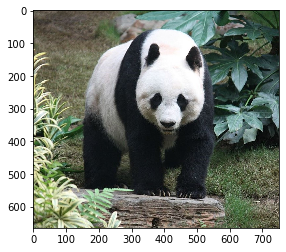

[[('n02510455', 'giant_panda', 0.8546536),
  ('n02132136', 'brown_bear', 0.007724042),
  ('n02134084', 'ice_bear', 0.004205322),
  ('n02509815', 'lesser_panda', 0.0035927717),
  ('n02447366', 'badger', 0.0034796346)]]

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
image = imread('../tests/data/panda.jpg')
image_size = model.input_shape[1]
plt.imshow(image, interpolation='nearest')
plt.show()
x = center_crop_and_resize(image, image_size=image_size)

x = preprocess_input(x, mode='torch')
inputs = np.expand_dims(x, 0)
expected = model.predict(inputs)
decode_predictions(expected)

## 3. Convert the model to ONNX

Now we use Keras2onnx to convert the model to ONNX format.

In [3]:
import keras2onnx
output_model_path = "keras_efficientNet.onnx"
onnx_model = keras2onnx.convert_keras(model, model.name)
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
The node number after optimization: 631 -> 290


## 4. Inference the ONNX Model with ONNX Runtime

Inference via ONNXRuntime:

In [4]:
import onnxruntime

sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)
data = [inputs.astype(np.float32)]
input_names = sess.get_inputs()
feed = zip(sorted(i_.name for i_ in input_names), data)

actual = sess.run(None, dict(feed))
decode_predictions(actual[0])

[[('n02510455', 'giant_panda', 0.85465264),
  ('n02132136', 'brown_bear', 0.0077241478),
  ('n02134084', 'ice_bear', 0.0042053456),
  ('n02509815', 'lesser_panda', 0.0035927782),
  ('n02447366', 'badger', 0.003479649)]]